# ETL efficiency measurements

### Dimensions

Inner radius of disk: 315mm (eta 1.659)

Outer radius of disk: 1185mm (eta 2.950)

In [1]:
%load_ext autoreload
%autoreload 2

import math
import time
import os.path
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from millisim.Environment import Environment
from millisim.Integrator import Integrator
from millisim.Detector import *
import millisim.Drawing as Drawing
from millisim.ETL import ETLSensor, ETLFace

# New packages that replace ROOT
import uproot
from yahist import Hist1D

def getEta(radius):
    return -math.log(math.tan(math.atan(radius/3000.)/2))


In [2]:
# Steering variables

mode = "VIS"
ntrajs = 20
pt_spect_filename = "../p_eta_dist/combined_PtSpect_Eta0p16.root"
dt = 0.1   #timestep in ns
max_nsteps = 10000
cutoff = 4.
use_var_dt = False
bfield_type = "cms"

particleQ = 1.0  # in electron charge units
particleM = 105. # in MEV

distToDetector = 3.
eta = 2.0 # should be different
rock_begins = 16. #??

detWidth = 1.0
detHeight = 1.0
detDepth = 1.0

etabounds = (1.659, 2.950)  ## full ETL disk.
#etabounds = (1.7, 2.8)  ## required coverage (?)
#etabounds = (1.7, 2.0)  ## required coverage (?)
#etabounds = (2.0, 2.5) # to check gaps
ptCut = 5. # 25
phibounds = (-np.pi/2, np.pi/2)
#phibounds = (0, np.pi/2)



useCustomMaterialFunction = False
#useCustomIntersectionFunction = False
useCustomOutput = False

## Set up the ETL detector

In [3]:
env = Environment(
    mat_setup = 'cms',
    bfield = bfield_type,
    bfield_file = "../bfield/bfield_coarse.pkl",
    rock_begins = rock_begins,
    rock_ends = distToDetector-0.10,
    mat_function = matFunction if useCustomMaterialFunction else None
)

## No magnetic field, for tests
#env = Environment(
#    mat_setup = 'cms',
#    bfield = None,
#    rock_begins = rock_begins,
#    rock_ends = distToDetector-0.10,
#    mat_function = matFunction if useCustomMaterialFunction else None
#)

itg = Integrator(
    environ = env,
    Q = particleQ,
    m = particleM,
    dt = dt,
    nsteps = max_nsteps,
    cutoff_dist = cutoff,
    cutoff_axis = 'z',
    use_var_dt = use_var_dt,
    lowv_dx = 0.01,
    multiple_scatter = 'pdg',
    do_energy_loss = True,
    randomize_charge_sign = False,
    )

plusZ1 = PlaneDetector(
    dist_to_origin = 3,
    eta = float("inf"),
    phi = 0.0,
    width = 1.13,
    height = 1.13,
)

plusZ2 = PlaneDetector(
    dist_to_origin = 3.1,
    eta = float("inf"),
    phi = 0.0,
    width = 1.13,
    height = 1.13,
)

minusZ = PlaneDetector(
    dist_to_origin = -3,
    eta = float("inf"),
    phi = 0.0,
    width = 2.5,
    height = 2.5,
)

ETLmod1 = ETLSensor(
    dist_to_origin = 3,
    x = 0.6,
    y = 0.0,
    width = 1.2,
    height = 2.26,
)

ETLmod2 = ETLSensor(
    dist_to_origin = 3.1,
    x = 0.6,
    y = 0.,
    width = 1.2,
    height = 2.26,
)

sensor = ETLSensor(
    dist_to_origin = 3,
    x = 0,
    y = 0,
    width = 0.0425,
    height = 0.022,
)

from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

with open('data/database.yaml') as f:
    database = load(f, Loader=Loader)

with open('data/database_TDR.yaml') as f:
    databaseTDR = load(f, Loader=Loader)

disk = database['TAMALES'] # no place reserved for services / MT connectors, but 6mm on edge of the disk
diskTDR = databaseTDR['TDR']

### TAMALES
# Disk 1 on the z+ side
TAMALES_face_plus_front1 = ETLFace(2.99825, disk['disk1']['front'], sensor, mirror=True)
TAMALES_face_plus_back1 = ETLFace(3.0055, disk['disk1']['back'], sensor, mirror=True)

# Disk 2 on the z+ side. Can have some offset to fill in inter-sensor and inter-module gaps
TAMALES_face_plus_front2 = ETLFace(3.02075, disk['disk2']['front'], sensor, offset_x=0.02, mirror=True)
TAMALES_face_plus_back2 = ETLFace(3.0285, disk['disk2']['back'], sensor, offset_y=0.02, mirror=True)

### TDR
# Disk 1 on the z+ side
TDR_face_plus_front1 = ETLFace(2.99825, diskTDR['disk1']['front'], sensor)
TDR_face_plus_back1 = ETLFace(3.0055, diskTDR['disk1']['back'], sensor)

# Disk 2 on the z+ side. Can have some offset to fill in inter-sensor and inter-module gaps
TDR_face_plus_front2 = ETLFace(3.02075, diskTDR['disk2']['front'], sensor, offset_x=0.02)
TDR_face_plus_back2 = ETLFace(3.0285, diskTDR['disk2']['back'], sensor, offset_y=0.02)


### This is what's used in the muon study below, and shown in the 3D plots
face_plus_front1 = TAMALES_face_plus_front1
face_plus_back1  = TAMALES_face_plus_back1
face_plus_front2 = TAMALES_face_plus_front2
face_plus_back2  = TAMALES_face_plus_back2

## for debugging
#ETLmodules = [ ETLSensor(dist_to_origin=3, x=x/1000., y=y/1000., width=0.0425, height=0.022) for x,y in centers  ]


## Get a pt distribution for particles to draw from

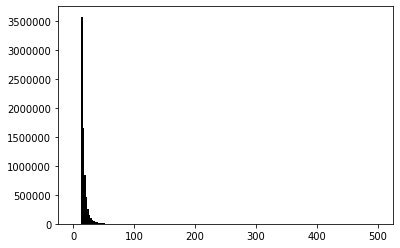

In [4]:
trajs = []
visWithStats = False

f = uproot.open(pt_spect_filename)
pt_in = f['pt']

# Check the pt distribution from which we will draw

pt_dist = Hist1D.from_bincounts(pt_in.values, bins=pt_in.edges)
pt_dist.plot(color="k")

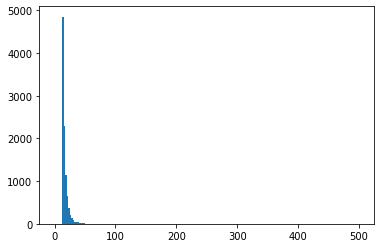

In [5]:
# Check if the sample function actually works as anticipated

test_dist = Hist1D(pt_dist.sample(10000), bins=pt_in.edges)
test_dist.plot()


In [6]:
starttime = time.time()

intersects = []
bar_intersects = []
ntotaltrajs = 0

statistics = [0,0,0,0,0] # maximum 4 hits
nTraj = 0
nMeas = 0
histogram = []
eta_distribution = []
eta_passed = []
pt_distribution  = []
phi_distribution = []
phi_passed = []
intersect_xy = []


while len(trajs)<ntrajs:
    nTraj += 1
    magp = 0
    
    etalow =  etabounds[0]
    etahigh =  etabounds[1]

    # draw random pT values from the distribution. Set minimum at 10 GeV
    while magp < ptCut:
        magp = pt_dist.sample(1)[0]

    # eta distribution is uniform for small eta
    eta = np.random.rand()*(etahigh-etalow) + etalow
    eta_distribution.append(eta)
    pt_distribution.append(magp)

    th = 2*np.arctan(np.exp(-eta))
    # magp = magp/np.sin(th)
    phimin, phimax =  phibounds
    phi = np.random.rand() * (phimax-phimin) + phimin
    phi_distribution.append(phi)
    itg.Q *= np.random.randint(2)*2 - 1 
    #phi *= itg.Q/abs(itg.Q)

    # convert to cartesian momentum in MeV
    p = 1000*magp * np.array([np.sin(th)*np.cos(phi),np.sin(th)*np.sin(phi),np.cos(th)])
    x0 = np.array([0,0,0,p[0],p[1],p[2]])
    
    # simulate until nsteps steps is reached, or the particle passes x=10
    traj,tvec = itg.propagate(x0)
    ntotaltrajs += 1
    if mode=="VIS":
        trajs.append(traj)
        print (len(trajs))
    
    
    nHits = 0
    for i_face, face in enumerate([face_plus_front1, face_plus_back1, face_plus_front2, face_plus_back2]):
        idict = face.find_intersection(traj, tvec)
        if i_face==0: intersect_xy.append((idict['x_int'][0], idict['x_int'][1]))
        if "t_int" in idict:
            nHits+=1
            eta_passed.append(eta)
            phi_passed.append(phi)
            continue
    
    if nHits>4: print ("Got more than 4 hits. Weird!")
    histogram.append(nHits)
    print (len(trajs), ": p =",magp, ", eta =", eta, ", phi =", phi)
    statistics[nHits] += 1
    
    if nHits>0:
        nMeas += 1
        print ("Intersected, current efficiency =", float(nMeas)/nTraj)
        

endtime = time.time()

1
1 : p = 13.75 , eta = 2.8680113855306466 , phi = -0.5214568149555836
Intersected, current efficiency = 1.0
2
2 : p = 18.75 , eta = 1.9006127568618556 , phi = 0.0903597633726172
Intersected, current efficiency = 1.0
3
3 : p = 23.75 , eta = 1.6990557415611665 , phi = -0.1969239002914398
Intersected, current efficiency = 1.0
4
4 : p = 13.75 , eta = 2.885859402068051 , phi = -0.35697705665920587
Intersected, current efficiency = 1.0
5
5 : p = 13.75 , eta = 2.3705670535234615 , phi = -0.46128021721580437
Intersected, current efficiency = 1.0
6
6 : p = 13.75 , eta = 2.6408995304225624 , phi = -1.4537050900821449
7
7 : p = 16.25 , eta = 1.7976417744123074 , phi = 0.593035260360419
Intersected, current efficiency = 0.8571428571428571
8
8 : p = 18.75 , eta = 2.1562943569411566 , phi = -0.279537289626018
Intersected, current efficiency = 0.875
9
9 : p = 23.75 , eta = 1.8947759111092015 , phi = 0.004528476534372716
Intersected, current efficiency = 0.8888888888888888
10
10 : p = 13.75 , eta = 2

In [7]:
print ("Efficiency:", sum(statistics[1:])/sum(statistics))
print ("Total time: {0:.2f} sec".format(endtime-starttime))
print ("Time/Hit: {0:.2f} sec".format((endtime-starttime)/ntrajs))

Efficiency: 0.95
Total time: 3.54 sec
Time/Hit: 0.18 sec


## Visualization of some trajectories, and the ETL detector

Use the trajectories that we just propagated throught the magnetic field, and see where they intersect with the modules/sensors.

This takes some time to run.


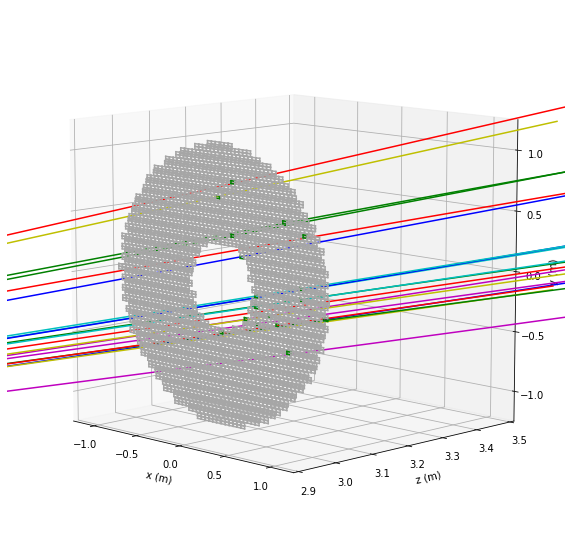

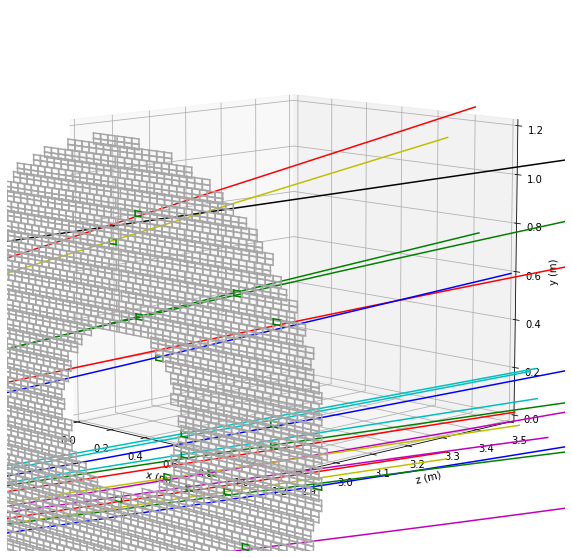

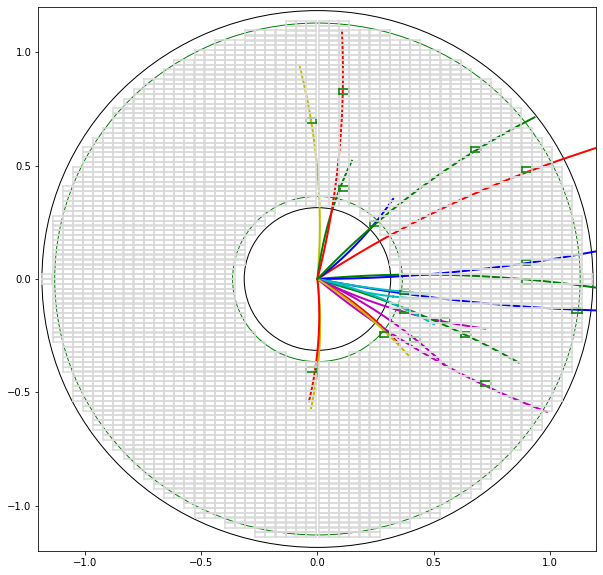

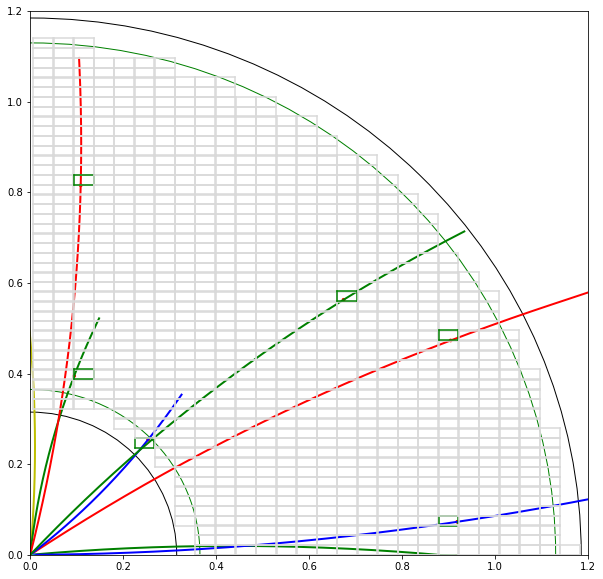

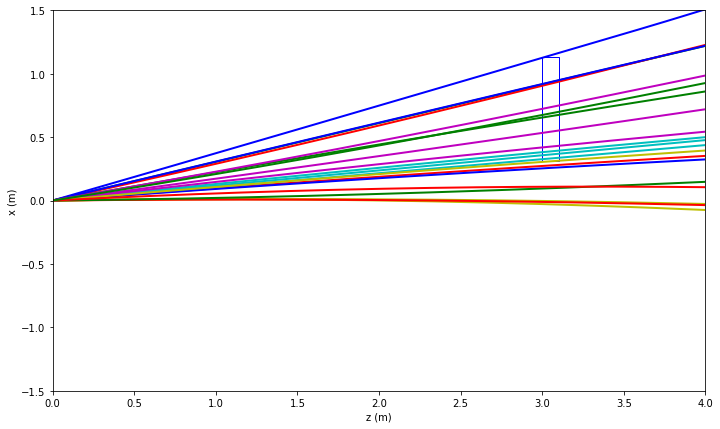

In [8]:

if mode=="VIS" or visWithStats:
    colors = ['r','g','b','c','m','y']
    
    ## 3D
    plt.figure(num=1, figsize=(10,10))
    Drawing.Draw3Dtrajs(trajs)    

    face_plus_front1.draw(plt.gca(), is3d=True, color='0.65')
    face_plus_back1.draw(plt.gca(), is3d=True, color='0.65')
    
    plt.gca().set_xlim(-1.2, 1.2)
    plt.gca().set_ylim(2.9, 3.5)
    plt.gca().set_zlim(-1.2, 1.2)
    
    plt.gca().view_init(elev=10., azim=-45)

    ### 3D
    plt.figure(num=2, figsize=(10,10))
    Drawing.Draw3Dtrajs(trajs)    

    face_plus_front1.draw(plt.gca(), is3d=True, color='0.65')
    face_plus_back1.draw(plt.gca(), is3d=True, color='0.65')
    
    plt.gca().set_xlim(0, 1.2)
    plt.gca().set_ylim(2.9, 3.5)
    plt.gca().set_zlim(0, 1.2)
    
    plt.gca().view_init(elev=10., azim=-45)
    
    
    ## 2D
    plt.figure(num=3, figsize=(10,10))
    Drawing.DrawXYslice(trajs)
    face_plus_front1.draw(plt.gca(), color='0.85')
    face_plus_back1.draw(plt.gca(), color='0.85')
    
    for int_xy in intersect_xy:
        plt.gca().add_patch(plt.Circle((int_xy[0], int_xy[1]), 0.003,fill='full', facecolor='red', edgecolor='red'))

    disk_inner = plt.Circle((0, 0), 0.315,fill=None, edgecolor='black')
    disk_outer = plt.Circle((0, 0), 1.185,fill=None, edgecolor='black')
    coverage_inner = plt.Circle((0, 0), 0.365,fill=None, edgecolor='green')
    coverage_outer = plt.Circle((0, 0), 1.130,fill=None, edgecolor='green')
        
    plt.gca().add_patch(disk_inner)
    plt.gca().add_patch(disk_outer)
    plt.gca().add_patch(coverage_inner)
    plt.gca().add_patch(coverage_outer)
    
    plt.gca().set_xlim((-1.2,1.2))
    plt.gca().set_ylim((-1.2,1.2))
    
    plt.figure(num=4, figsize=(10,10))
    Drawing.DrawXYslice(trajs)
    face_plus_front1.draw(plt.gca(), color='0.85')
    face_plus_back1.draw(plt.gca(), color='0.85')
    
    for int_xy in intersect_xy:
        plt.gca().add_patch(plt.Circle((int_xy[0], int_xy[1]), 0.003,fill='full', facecolor='red', edgecolor='red'))

    disk_inner = plt.Circle((0, 0), 0.315,fill=None, edgecolor='black')
    disk_outer = plt.Circle((0, 0), 1.185,fill=None, edgecolor='black')
    coverage_inner = plt.Circle((0, 0), 0.365,fill=None, edgecolor='green')
    coverage_outer = plt.Circle((0, 0), 1.130,fill=None, edgecolor='green')
    
    plt.gca().add_patch(disk_inner)
    plt.gca().add_patch(disk_outer)
    plt.gca().add_patch(coverage_inner)
    plt.gca().add_patch(coverage_outer)
    
    plt.gca().set_xlim((0,1.2))
    plt.gca().set_ylim((0,1.2))
    
    plt.figure(num=5, figsize=(11.7,7))
    Drawing.DrawXZslice(trajs)#, drawBFieldFromEnviron=env, drawColorbar=True)
    #face_plus_front1.draw(plt.gca(), isXZ=True, c='0.65')
    
    outline = [
        [3, 0.315],
        [3, 1.13],
        [3.1, 1.13],
        [3.1, 0.315]
    ]
    upper = plt.Polygon(outline, closed=True, fill=None, edgecolor='b')
    plt.gca().add_patch(upper)
    plt.gca().set_xlim((0,4))
    plt.gca().set_ylim((-1.5,1.5))
    
    plt.show()

- above 99% efficient for eta 2-2.5
- ~87% efficient for eta 1.659 and 2.950
- 96% eta 1.7-2.8, 70% have at least two hits

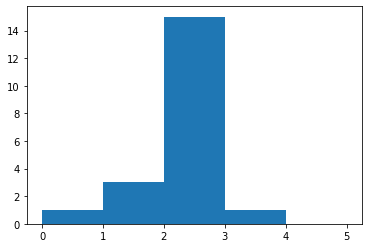

In [9]:
h, x_edge, img = plt.hist(histogram, bins=5, range=[0,5])


In [10]:
print ("No hit:", h[0]/h.sum())
print ("At least one hit:", h[1:].sum()/h.sum())
print ("At least two hits:", h[2:].sum()/h.sum())

No hit: 0.05
At least one hit: 0.95
At least two hits: 0.8


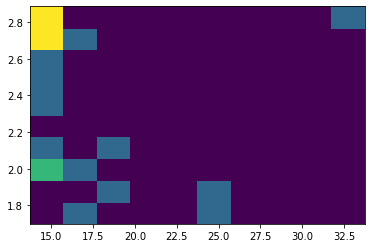

In [11]:
h, x_edge, y_edge, img = plt.hist2d(pt_distribution, eta_distribution)

(array([2., 2., 3., 2., 0., 1., 1., 1., 4., 4.]),
 array([1.69905574, 1.81773611, 1.93641647, 2.05509684, 2.17377721,
        2.29245757, 2.41113794, 2.5298183 , 2.64849867, 2.76717904,
        2.8858594 ]),
 <a list of 10 Patch objects>)

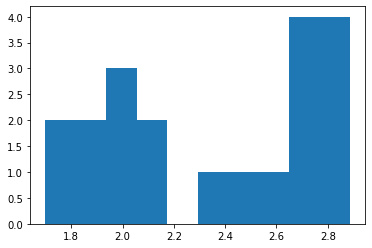

In [12]:
plt.hist(eta_distribution)

(array([12.,  3.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([13.75, 15.75, 17.75, 19.75, 21.75, 23.75, 25.75, 27.75, 29.75,
        31.75, 33.75]),
 <a list of 10 Patch objects>)

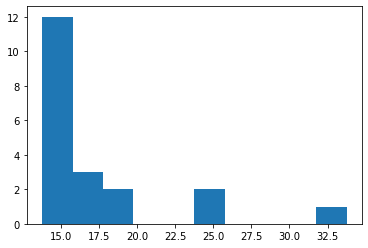

In [13]:
plt.hist(pt_distribution)

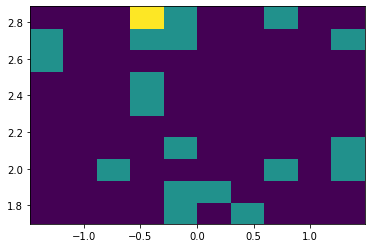

In [14]:
h, x_edge, y_edge, img = plt.hist2d(phi_distribution, eta_distribution)

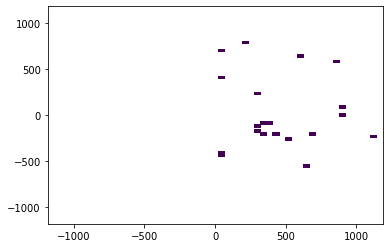

In [15]:
# all muons
theta = 2*np.arctan(np.exp(np.array(eta_distribution)*(-1)))
r = 3000*np.tan(theta)
x = r*np.cos(phi_distribution)
y = r*np.sin(phi_distribution)
h_all, x_edge, y_edge, img = plt.hist2d(x, y, bins=[int(2*1185/43),int(2*1185/29)], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

In [16]:
h_all

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

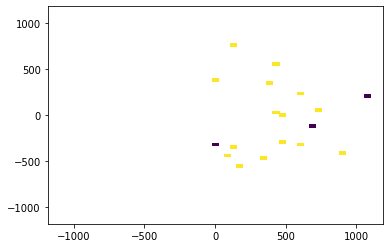

In [18]:
# intersected muons
theta = 2*np.arctan(np.exp(np.array(eta_passed)*(-1)))
r = 3000*np.tan(theta)
x = r*np.cos(phi_passed)
y = r*np.sin(phi_passed)
h_passed, x_edge, y_edge, img = plt.hist2d(x, y, bins=[int(2*1185/43),int(2*1185/29)], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

In [19]:
H = h_passed/h_all

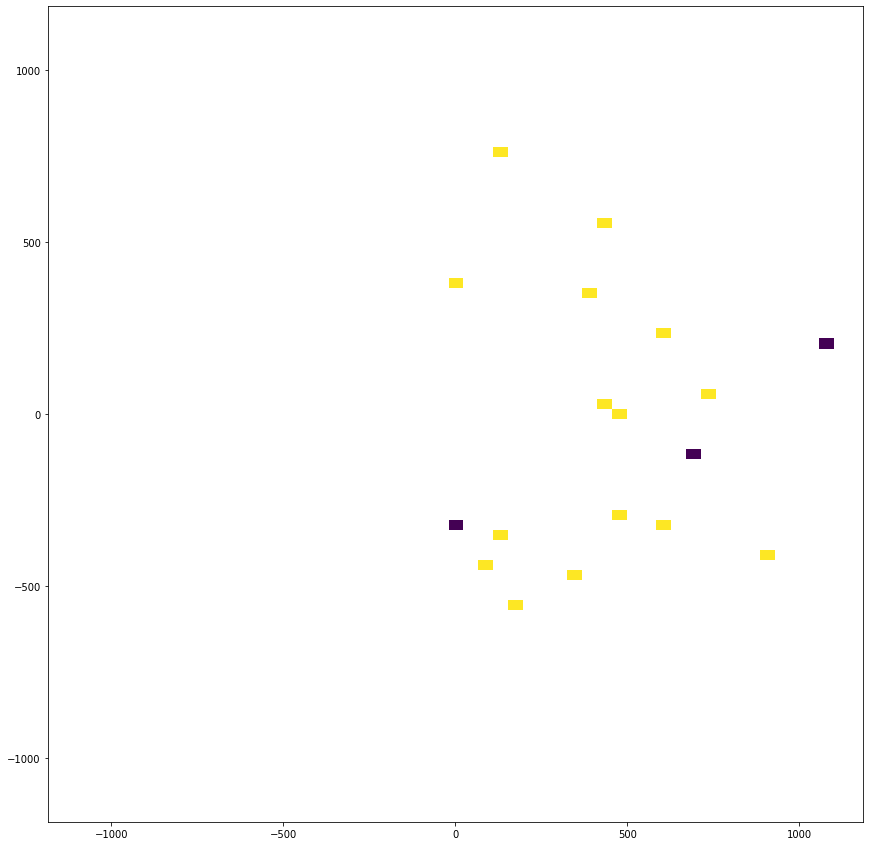

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(H.T, interpolation='nearest', origin='low',extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
#plt.imshow(H.T, interpolation='nearest', origin='low',extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])

In [31]:
import random

starttime = time.time()

x_all = np.array([])
y_all = np.array([])
x_TDR_passed = np.array([])
y_TDR_passed = np.array([])
x_TAMALES_passed = np.array([])
y_TAMALES_passed = np.array([])

eta_max = 2.950
eta_min = 1.659
eta_range = eta_max-eta_min
theta_max = 2*np.arctan(np.exp(eta_max*(-1)))
theta_min = 2*np.arctan(np.exp(eta_min*(-1)))
theta_range = theta_min-theta_max

nEvents = int(1e4)

theta = np.random.rand(nEvents)*theta_range + theta_max
phi = np.random.rand(nEvents)*2*np.pi - np.pi
r = 3000*np.tan(theta)
vx = r*np.cos(phi)
vy = r*np.sin(phi)

for x,y in zip(vx,vy):
    
    TDR_intersect = False
    for face in [TDR_face_plus_front1, TDR_face_plus_front2, TDR_face_plus_back1, TDR_face_plus_back2]:
        if face.find_intersection_fast(x/1000,y/1000):
            TDR_intersect = True
            break
    
    if TDR_intersect:
        x_TDR_passed = np.append(x_TDR_passed, [x])
        y_TDR_passed = np.append(y_TDR_passed, [y])
    
    
    TAMALES_intersect = False
    for face in [TAMALES_face_plus_front1, TAMALES_face_plus_front2, TAMALES_face_plus_back1, TAMALES_face_plus_back2]:
        if face.find_intersection_fast(x/1000,y/1000):
            TAMALES_intersect = True
            break
    
    if TAMALES_intersect:
        x_TAMALES_passed = np.append(x_TAMALES_passed, [x])
        y_TAMALES_passed = np.append(y_TAMALES_passed, [y])
            
    x_all = np.append(x_all, [x])
    y_all = np.append(y_all, [y])
    
    
endtime = time.time()

print (endtime-starttime)

26.32601499557495


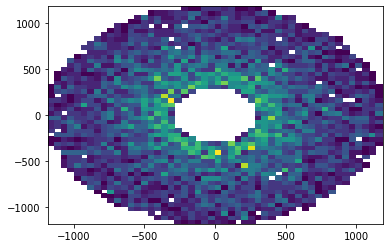

In [32]:
# all muons
h_all, x_edge, y_edge, img = plt.hist2d(x_all, y_all, bins=[50,50], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

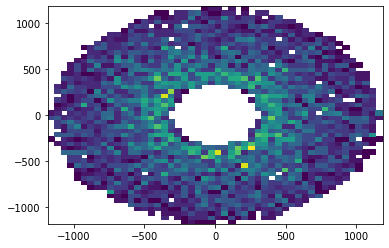

In [33]:
# intersected muons with TDR
h_TDR_passed, x_edge, y_edge, img = plt.hist2d(x_TDR_passed, y_TDR_passed, bins=[50,50], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

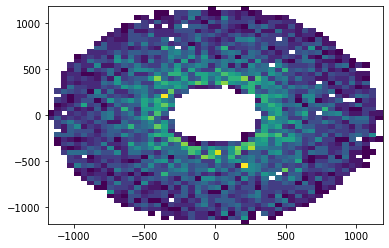

In [34]:
# intersected muons with TAMALES
h_TAMALES_passed, x_edge, y_edge, img = plt.hist2d(x_TAMALES_passed, y_TAMALES_passed, bins=[50,50], range=[[-1185,1185], [-1185,1185]], cmin = 0.0001)

In [35]:
len(TDR_face_plus_back1.x)

2024

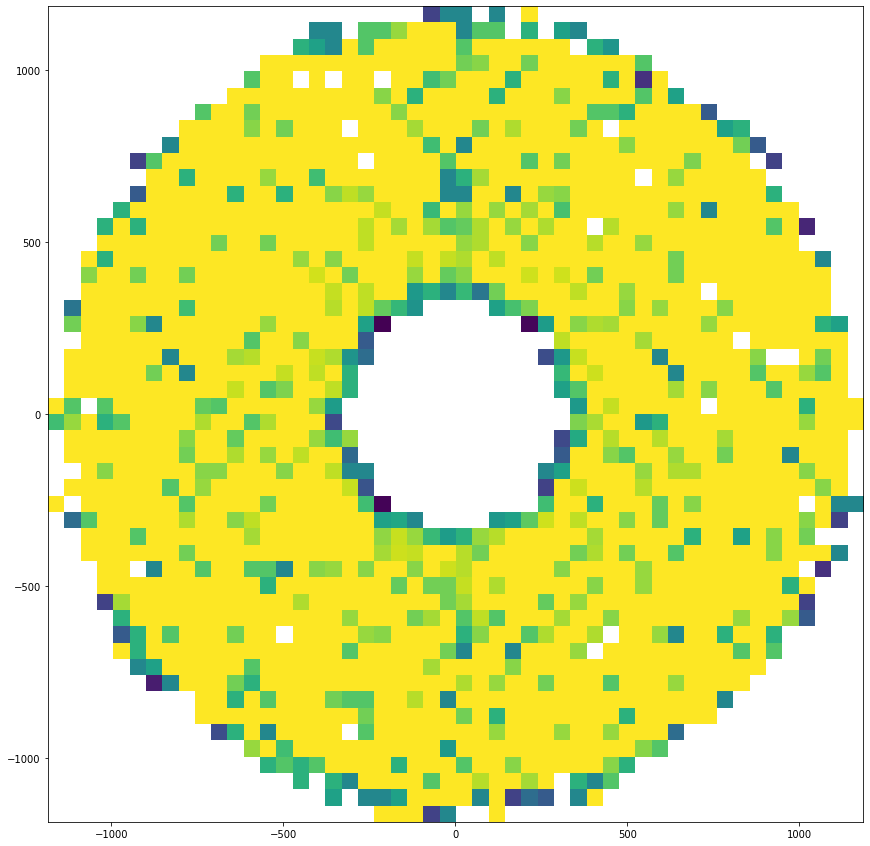

In [36]:
# TDR efficiencies
#H = np.nan_to_num(h_TDR_passed/h_all, 0)
H = h_TDR_passed/h_all
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(H.T, interpolation='nearest', origin='low',extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])


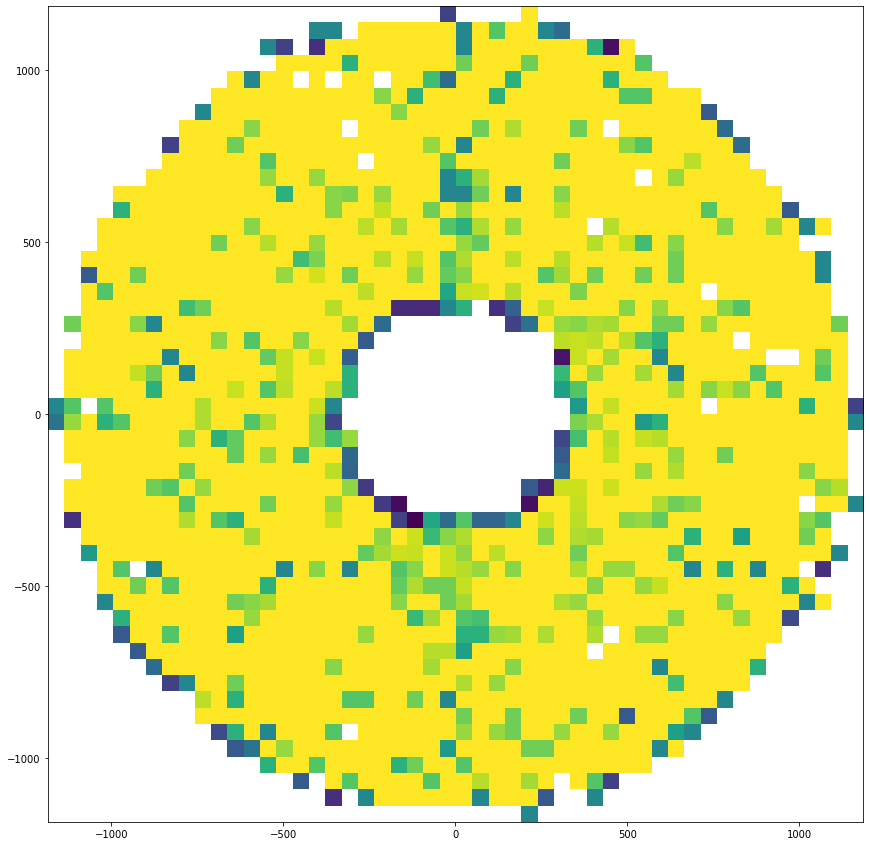

In [37]:
# TAMALES efficiencies
#H = np.nan_to_num(h_TAMALES_passed/h_all, -1)
H = h_TAMALES_passed/h_all
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(H.T, interpolation='nearest', origin='low',extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])



In [38]:
## Overall efficiency

print ("# TDR design:")
print ("  %.3f"%(float(len(x_TDR_passed))/len(x_all)))
print ("# TAMALES design:")
print ("  %.3f"%(float(len(x_TAMALES_passed))/len(x_all)))

# TDR design:
  0.884
# TAMALES design:
  0.883


In [40]:
len(x_TAMALES_passed)

8834